In [1]:
%cd ../..

C:\Users\Dongmin Kim\Documents\OnlineTSAD\Vis
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD\Vis 디렉터리

2023-05-08  오후 06:26    <DIR>          .
2023-05-08  오후 06:26    <DIR>          ..
2023-05-04  오후 08:21    <DIR>          .ipynb_checkpoints
2023-05-08  오후 06:26        12,412,706 MSL_P-15_online_OCSVM.ipynb
2023-04-30  오후 03:05        12,287,231 MSL_P-15_online_tsne.ipynb
2023-04-11  오후 01:28        13,802,393 NTS_online_v8_ARevIN.ipynb
2023-05-02  오후 01:04        16,151,824 NTSNUI_online_tsne.ipynb
2023-04-12  오후 03:27    <DIR>          prev
2023-04-12  오후 03:28    <DIR>          prev2-before revins
2023-05-04  오후 08:18    <DIR>          results
2023-04-19  오후 08:16        47,451,697 SWaT_online_v10_ARevIN_gth.ipynb
2023-04-24  오후 05:13        42,624,419 SWaT_online_v11_ARevIN_POT.ipynb
2023-04-11  오후 08:54         7,917,879 SWaT_online_v8_ARevIN.ipynb
2023-04-15  오후 07:46        13,177,790 SWaT_online_v9_ARevIN_SSL.ipynb
2023-04-11  오후 05:2

In [3]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils.metrics import get_auroc, get_summary_stats

ImportError: cannot import name 'get_auroc' from 'utils.metrics' (C:\Users\Dongmin Kim\Documents\OnlineTSAD\utils\metrics.py)

In [3]:
from torch import optim

In [4]:
from models.MLP import MLP
import matplotlib.pyplot as plt

In [5]:
import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything

import warnings
from data.load_data import DataFactory
from Exp.SklearnBaselines import *
from Exp.ReconBaselines import *
from Exp.Baselines import *

from easydict import EasyDict as edict
import yaml
import re

warnings.filterwarnings("ignore")

In [6]:
def get_metrics(gt, anomaly_scores, threshold):
    result = {}
    # AUROC
    auc = get_auroc(gt, anomaly_scores, threshold)
    result.update({"AUC": auc})

    # F1
    pred = (anomaly_scores > threshold).astype(int)
    metrics = get_summary_stats(gt, pred)
    result.update(metrics)

    return result

In [7]:
def plot_anomaly(ax, test_y):
    s, e = None, None
    for i in range(len(test_y)):
        if test_y[i] == 1 and s is None:
            s = i
        elif test_y[i] == 0 and s is not None:
            e = i - 1
            if (e - s) > 0:
                ax.axvspan(s, e, facecolor='red', alpha=0.5)
            else:
                ax.axvspan(s-0.5, s+0.5, facecolor='red', alpha=0.5)
            s, e = None, None

In [8]:
model = "MLP"
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

with open("cfgs/defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [9]:
args = prepare_arguments(cfg)

args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1

print(args)

{'exp_id': 'MLP_NeurIPS-TS-MUL', 'dataset': 'NeurIPS-TS-MUL', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_NeurIPS-TS-MUL', 'log_path': './logs/MLP_NeurIPS-TS-MUL', 'output_path': './outputs/MLP_NeurIPS-TS-MUL', 'plot_path': './plots/MLP_NeurIPS-TS-MUL', 'result_path': './results/MLP_NeurIPS-TS-MUL', 'thresholding': 'oracle', 'load_pretrained': True, 'eval_every_epoch': False, 'anomaly_reduction_mode': 'mean', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}


In [10]:
logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]

[2023-03-15 01:48:50,090] Configurations: {'exp_id': 'MLP_NeurIPS-TS-MUL', 'dataset': 'NeurIPS-TS-MUL', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'lr': 0.001, 'epochs': 30, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_NeurIPS-TS-MUL', 'log_path': './logs/MLP_NeurIPS-TS-MUL', 'output_path': './outputs/MLP_NeurIPS-TS-MUL', 'plot_path': './plots/MLP_NeurIPS-TS-MUL', 'result_path': './results/MLP_NeurIPS-TS-MUL', 'thresholding': 'oracle', 'load_pretrained': True, 'eval_every_epoch': False, 'anomaly_reduction_mode': 'mean', 'defaults': [{'model': 'OCSVM'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'home_dir': '.', 'device': device(type='cuda')}
[2023-03-15 01:48:50,098] Preparing NeurIPS-TS-MUL dataset...
[2023-03-15 01:48:50,102] current location: /home/nas3_userJ/dmkim/TSADBench
[2023-03-15 01:48:50,106] home dir: .
[2023-03-15 01:48:50,108] Preparing NeurIPS-TS-MUL ...
[2023-03-15 01:48:50,242] train: X - (100

In [11]:
train_X, train_y = train_dataset.X, train_dataset.y
test_X, test_y = test_dataset.X, test_dataset.y

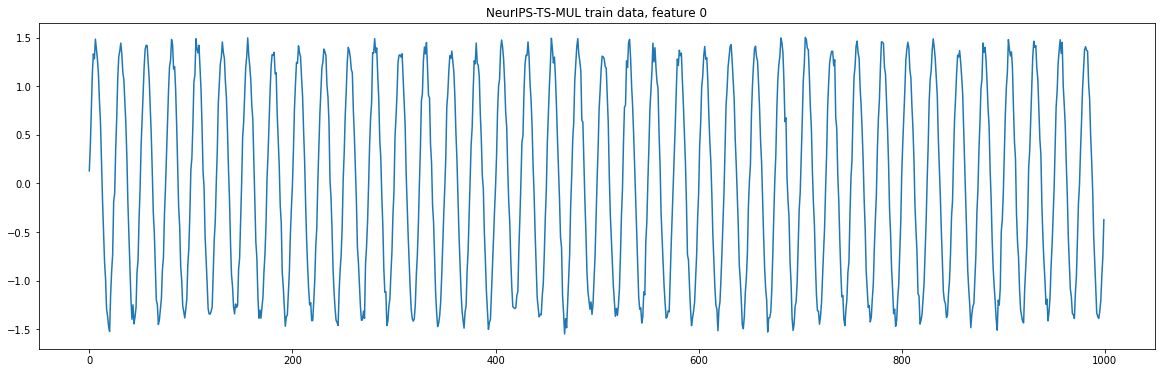

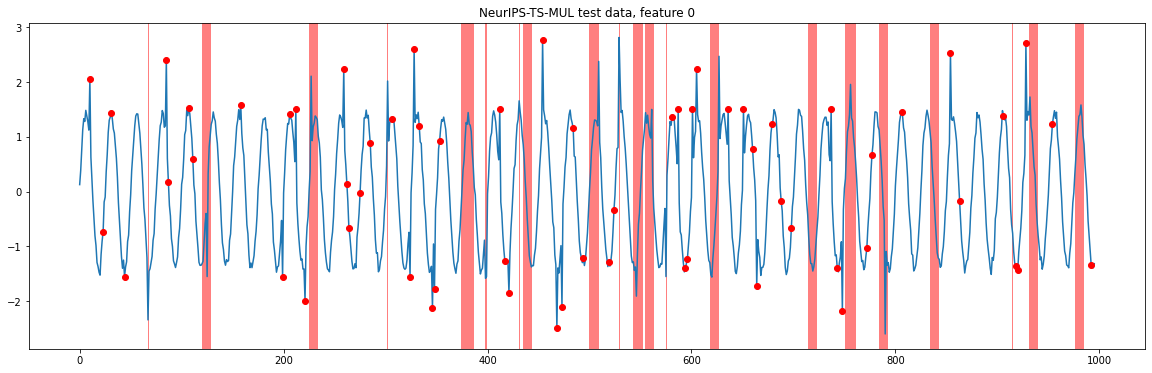

In [12]:
C = 0
dataset = "NeurIPS-TS-MUL"
datafactory.visualize_dataset(train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y, dataset_name=dataset, feature_idx=C)

## Load Model

In [13]:
trainer = MLP_Trainer(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)

In [14]:
trainer.load(os.path.join("./checkpoints/MLP_NeurIPS-TS-MUL", f"best.pth"))

[2023-03-12 07:48:06,814] loading: ./checkpoints/MLP_NeurIPS-TS-MUL/best.pth @Trainer - torch.load_state_dict


In [15]:
next(iter(trainer.model.parameters())).device, next(iter(trainer.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

## Training statistics

In [16]:
train_iterator = tqdm(
    trainer.train_loader,
    total=len(trainer.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(trainer.args.device)
        B, L, C = X.shape
        Xhat = trainer.model(X.reshape(B, L*C)).reshape(B, L, C)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)
print(recon_errors.shape)
train_error_dist = recon_errors.mean(dim=(1, 2))

calculating reconstruction errors: 100%|██████████| 16/16 [00:00<00:00, 29.59it/s]

torch.Size([989, 12, 5])


In [17]:
eval_iterator = tqdm(
    trainer.test_loader,
    total=len(trainer.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(trainer.args.device), batch_data[1].to(trainer.args.device)
        B, L, C = X.shape
        Xhat = trainer.model(X.reshape(B, L*C)).reshape(B, L, C)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 83/83 [00:00<00:00, 2059.75it/s]


### Label-guided Online learning

In [18]:
init_thr = torch.quantile(train_error_dist, 0.95).item()

In [19]:
thr = torch.tensor(init_thr, requires_grad=True)
thr

tensor(0.0066, requires_grad=True)

In [20]:
eval_iterator = tqdm(
    trainer.test_loader,
    total=len(trainer.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TH_optimizer = torch.optim.SGD([thr]+[p for p in trainer.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs = []
Xhats = []
yhats = []
anoscs=[]
thrs = []
preds = []
for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(trainer.args.device), batch_data[1].to(trainer.args.device)
    Xs.append(X)
    
    # infer
    B, L, C = X.shape
    Xhat = trainer.model(X.reshape(B, L*C)).reshape(B, L, C)
    Xhats.append(Xhat)
    
    e = F.mse_loss(Xhat, X, reduction='none')
    anosc = e.mean(dim=2)
    anoscs.append(anosc)
    thrs.append(thr.item())
    pred = (anosc > thr)
    preds.append(pred)
    
    # update
    TH_optimizer.zero_grad()
    ## 1. classifier_loss
    
    #import pdb;pdb.set_trace();
    # loss 1: standardized
    # yhat = torch.sigmoid((anosc-thr)/(torch.std(anosc)))
    # loss 2: diff
    #yhat = torch.sigmoid(anosc-thr)
    #yhats.append(yhat)
    #cls_loss = bce(yhat, y.float())
    
    # loss3: svm
    margin = 0.5
    _y = 2*y-1
    yhat = torch.tanh((anosc-thr)/(torch.std(anosc)))
    yhats.append(yhat)
    cls_loss = torch.clamp(margin-(_y*yhat), min=0).mean()
    
    ## 2. masked recon loss
    mask = ((y == 0).unsqueeze(2))
    recon_loss = 0 if (mask.sum() == 0) else ((e*mask).sum() / mask.sum())
    # loss backward
    print(cls_loss, recon_loss)
    loss = cls_loss + recon_loss
    loss.backward()
    TH_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()
yhats = torch.cat(yhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(anoscs, axis=0).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size)

preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors:  24%|██▍       | 20/83 [00:00<00:00, 191.74it/s]

tensor(0.4489, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0290, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0926, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0271, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0628, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0433, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1249, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0467, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.2378, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0212, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0769, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5345, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1330, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0389, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0884, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0534, device='cuda:0', grad_fn

calculating reconstruction errors:  72%|███████▏  | 60/83 [00:00<00:00, 195.17it/s]

tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>) tensor(13.6012, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3750, device='cuda:0', grad_fn=<MeanBackward0>) tensor(14.0189, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8748, device='cuda:0', grad_fn=<MeanBackward0>) tensor(12.7437, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4081, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.4617, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1256, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2323, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1956, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5852, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.2312, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5649, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5602, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1847, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0874, device='cuda:0', grad

calculating reconstruction errors: 100%|██████████| 83/83 [00:00<00:00, 194.32it/s]

tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.6287, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1997, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.0308, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1856, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.3740, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5670, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8197, device='cuda:0', grad_fn=<DivBackward0>)


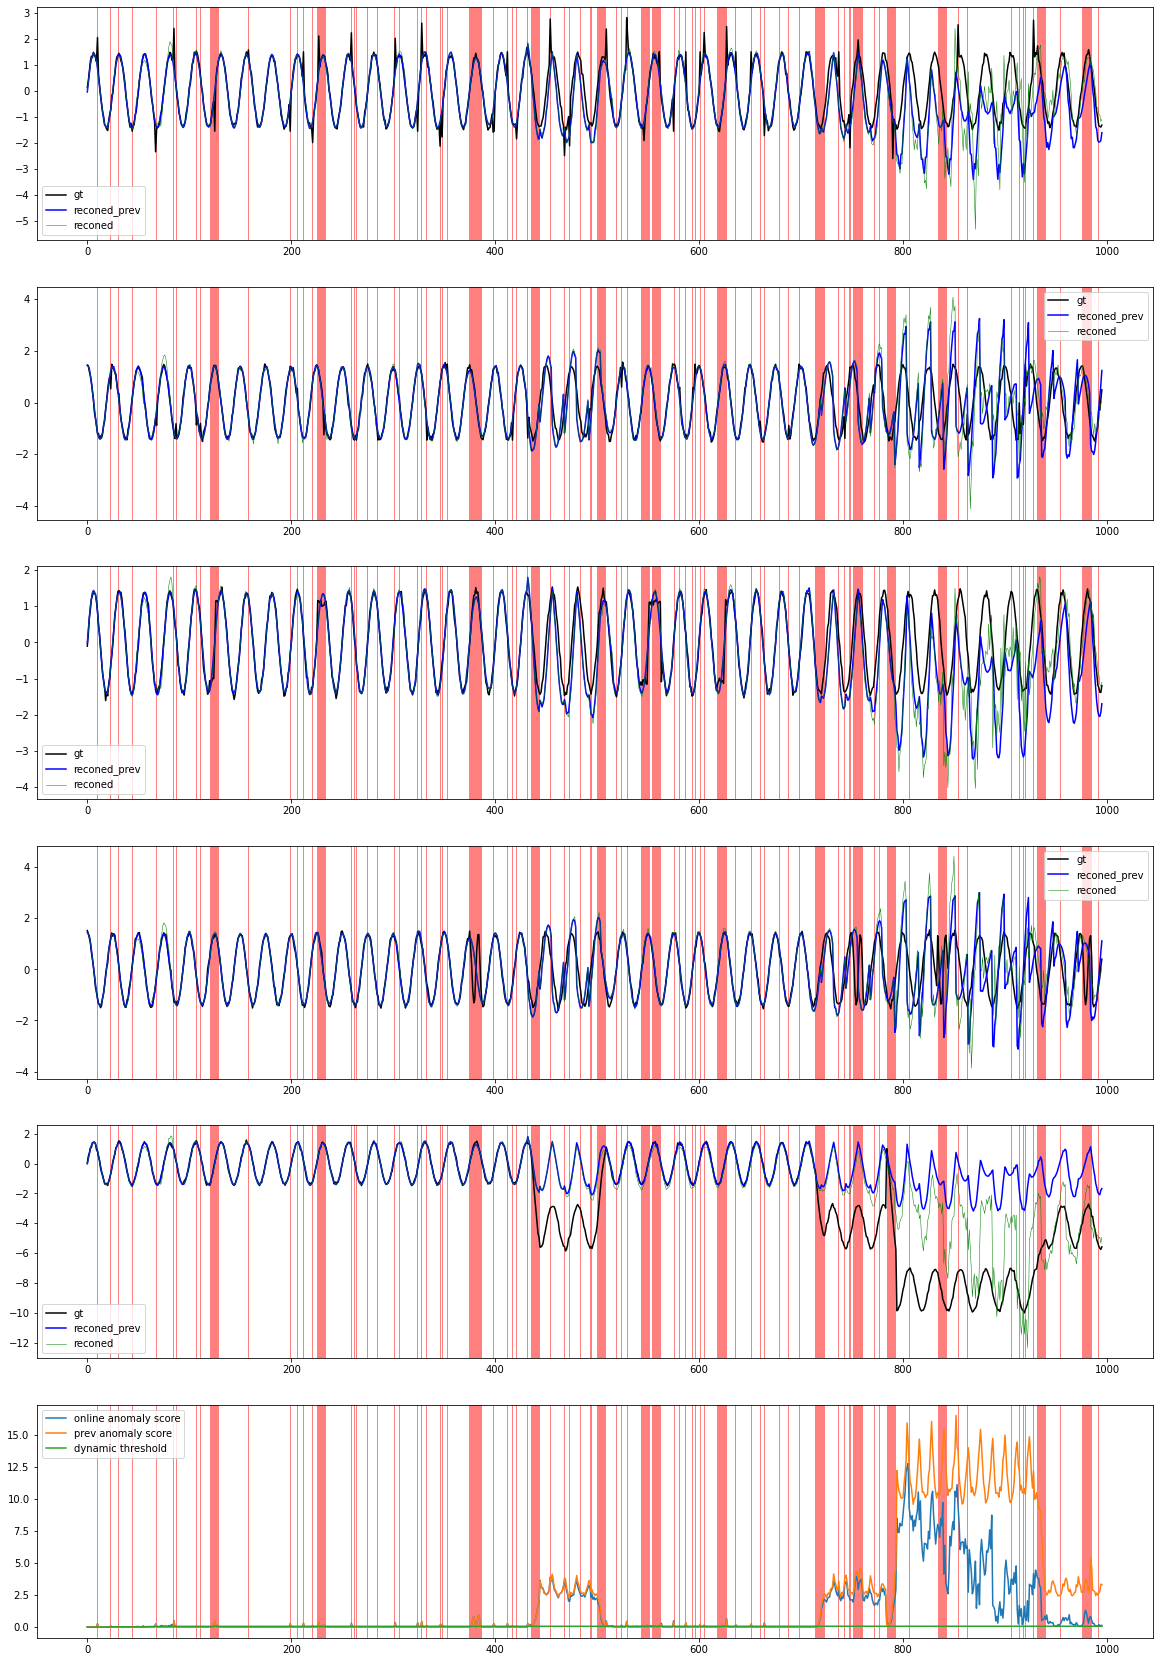

In [21]:
# plot abnormal
test_X, test_y = test_dataset.X, test_dataset.y

B, L, C = Xhats.shape

fig, ax = plt.subplots(6, 1, figsize=(20, 30))

for c in range(args.num_channels):
    # gt
    ax[c].plot(test_X[:, c], color="black", label="gt")
    plot_anomaly(ax[c], test_y)
    
    # reconed
    ax[c].plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed_prev")
    ax[c].plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed")
    ax[c].legend()


ax[5].plot(anoscs.reshape(-1), label="online anomaly score")
ax[5].plot(anoscs_prev.reshape(-1), label="prev anomaly score")

ax[5].plot(thrs, label="dynamic threshold")
ax[5].legend()
plot_anomaly(ax[5], test_y)

plt.show()

In [22]:
len(preds), preds[0].shape

(996, ())

In [23]:
get_summary_stats(test_y, preds)

{'Accuracy': 0.6495983935742972,
 'Precision': 0.35600907029478457,
 'Recall': 0.7072072072072072,
 'F1': 0.47360482654600305,
 'tn': 490,
 'fp': 284,
 'fn': 65,
 'tp': 157}

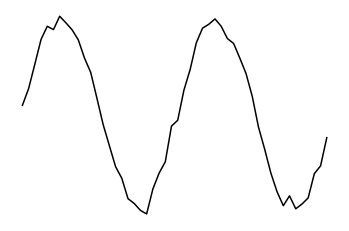

In [47]:
#plt.figure(figsize=(20, 6))
plt.plot(train_X[0:50, 0], color="black")
#plt.plot(train_X[0:50, 0]-np.random.randn(50), color="blue", label="gt")
plt.axis("off")
plt.show()

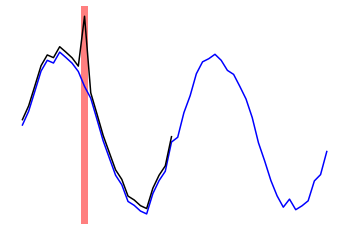

In [53]:
#plt.figure(figsize=(20, 6))
plt.plot(train_X[0:50, 0]-0.1, color="blue", label="gt")
plt.plot(test_X[0:25, 0]+, color="black", label="gt")

plot_anomaly(plt, test_y[0:20])
plt.axis("off")
plt.show()

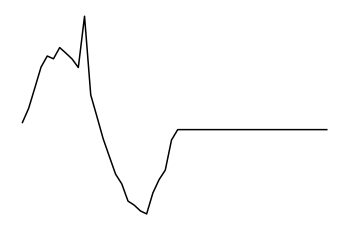

In [13]:
#plt.figure(figsize=(20, 6))
#plt.plot(train_X[0:50, 0]-0.1, color="blue", label="gt")
plt.plot(np.concatenate([test_X[0:25, 0], np.array([0 for _ in range(25)])]), color="black", label="gt")

#plot_anomaly(plt, test_y[0:20])
plt.axis("off")
plt.show()

